# DIGLM demonstration

In this notebook we illustrate with a toy model the usage of the DIGLM class.

In [7]:
! git clone https://github.com/MarcoRiggirello/diglm.git

import os
import sys
sys.path.append('diglm/diglm')

import tensorflow as tf
from tensorflow import Variable, ones, zeros
from tensorflow_probability import glm
from tensorflow_probability import distributions as tfd
from tensorflow.keras import metrics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from Diglm import DIGLM
from spqr import NeuralSplineFlow as NSF

fatal: destination path 'diglm' already exists and is not an empty directory.


## Toy dataset

The feature vectors $x_1$ and $x_2$ are from multivariate normal distribution with $\mu = [-1, 1]$ and $cov =
 \begin{pmatrix} 
 1 & -0.3 \\ -0.3 & 1
 \end{pmatrix}$.
The response is $y = (x_1 + x_2)^3$.  

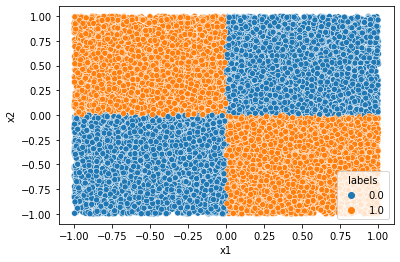

In [8]:
BATCH_SIZE = 128
DATASET_SIZE = BATCH_SIZE * 128

X1 = np.random.uniform(low=-1, high=1, size=DATASET_SIZE)
X2 = np.random.uniform(low=-1, high=1, size=DATASET_SIZE)
response = lambda x1, x2: x1 * x2 > 1 / (x1 * x2) 

df = pd.DataFrame(np.stack((response(X1, X2), X1, X2), axis=1),
                  columns=['labels','x1', 'x2'])
sns.scatterplot(data=df, x='x1', y='x2', hue='labels', cmap='magma')

bandiera = tf.data.Dataset.from_tensor_slices(df[['x1', 'x2']].astype('float32'))
bandiera = bandiera.prefetch(tf.data.experimental.AUTOTUNE)
bandiera = bandiera.cache()
bandiera = bandiera.shuffle(DATASET_SIZE)
bandiera = bandiera.batch(BATCH_SIZE)

bandiera_l = tf.data.Dataset.from_tensor_slices(df[['labels']].astype('int32'))
bandiera_l = bandiera_l.prefetch(tf.data.experimental.AUTOTUNE)
bandiera_l = bandiera_l.cache()
bandiera_l = bandiera_l.shuffle(DATASET_SIZE)
bandiera_l = bandiera_l.batch(BATCH_SIZE)

## Building the DIGLM 

We initialize our diglm model with a linear glm

In [9]:
my_glm = glm.Bernoulli()
neural_spline_flow = NSF(splits=2)
diglm = DIGLM(neural_spline_flow, my_glm, 2)

train_dict = [{'labels': batch_l,
              'features': batch_ft}
              for batch_l, batch_ft in zip(bandiera_l, bandiera)]

trans_distr = tfd.TransformedDistribution(distribution=tfd.MultivariateNormalDiag(
                    loc=zeros([diglm.num_features]),
                    scale_diag=ones([diglm.num_features])
                ),
                bijector=diglm.bijector)

def plot(): 
  trans_sample = trans_distr.sample(DATASET_SIZE)
  mean_sample, var_sample, grad_sample  = diglm(trans_sample)
  x1, x2 = np.split(trans_sample.numpy(), 2, axis=1)
  x1 = np.concatenate(x1)
  x2 = np.concatenate(x2)
  mean = np.concatenate(mean_sample.numpy().T)
  ex_df = pd.DataFrame(np.stack((mean, x1, x2), axis=1),
                     columns=['labels', 'x1', 'x2'])
  sns.scatterplot(data=ex_df, x='x1', y='x2', hue='labels', cmap='magma')
  plt.show() 

## Training functions



In [10]:
@tf.function
def train_step(optimizer, target_sample):
    """
    Train step function for the diglm model. Implements the basic steps for computing
    and updating the trainable variables of the model. It also
    calculates the loss on training and validation samples.

    :param optimizer: Optimizer fro gradient minimization (or maximization).
    :type optimizer: A keras.optimizers object
    :param target_sample: dictonary of labels and features of data to train the model
    :type target_sample: dict

    """

    with tf.GradientTape() as tape:
        # calculating loss and its gradient of training data
        loss = -tf.reduce_mean(diglm.weighted_log_prob(target_sample))
    variables = tape.watched_variables()
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss

tf.Tensor(
[[1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]], shape=(128, 1), dtype=int32)
[[0.29182398]
 [0.3784334 ]
 [0.77766716]
 [0.45666108]
 [0.25884724]
 [0.6736226 ]
 [0.70850325]
 [0.36310297]
 [0.5726451 ]
 [0.5771239 ]
 [0.58372205]
 [0.5942879 ]
 [0.32890177]
 [0.42646658]
 [0.21720994]
 [0.5914484 ]
 [0.29658088]
 [0.19425172]
 [0.21018505]
 [0.42550087]
 [0.40607116]
 [0.573352  ]
 [0.675902

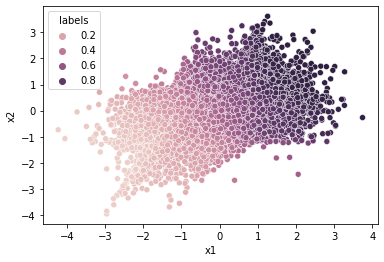

Binary accuracy: 0.453
Epoch = 2 Loss = 0.902.


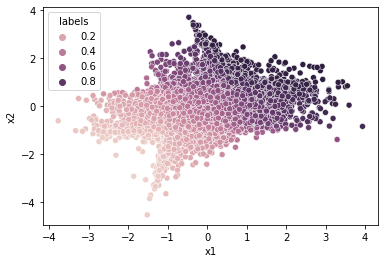

Binary accuracy: 0.477
Epoch = 3 Loss = 0.878.


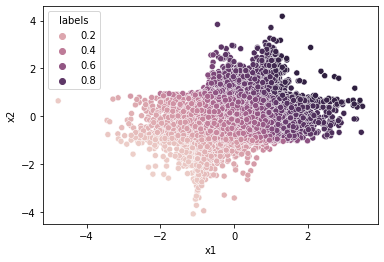

Binary accuracy: 0.492
Epoch = 4 Loss = 0.861.


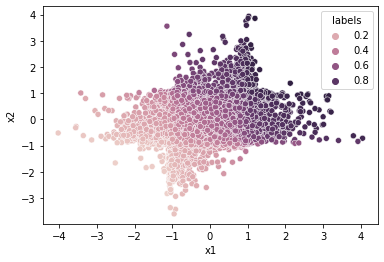

Binary accuracy: 0.469
Epoch = 5 Loss = 0.849.


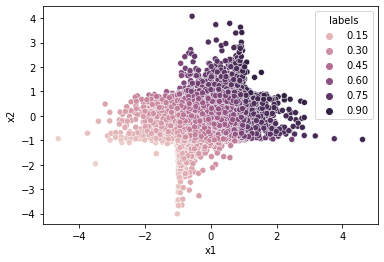

Binary accuracy: 0.477
Epoch = 6 Loss = 0.844.


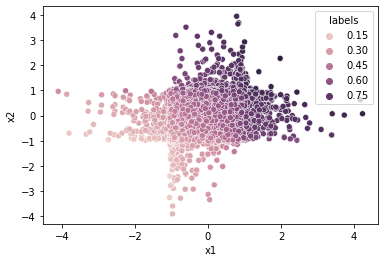

Binary accuracy: 0.461
Epoch = 7 Loss = 0.836.


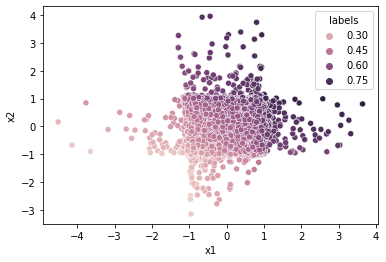

Binary accuracy: 0.469
Epoch = 8 Loss = 0.826.


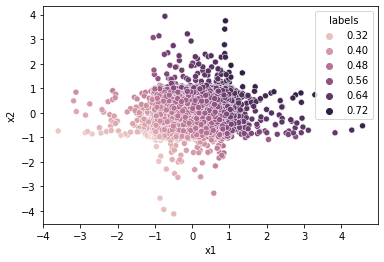

Binary accuracy: 0.500
Epoch = 9 Loss = 0.827.


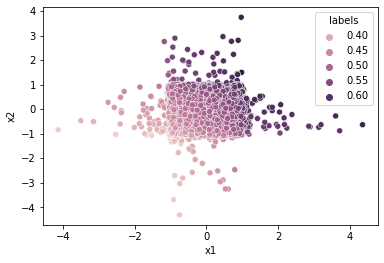

Binary accuracy: 0.469
Epoch = 10 Loss = 0.832.


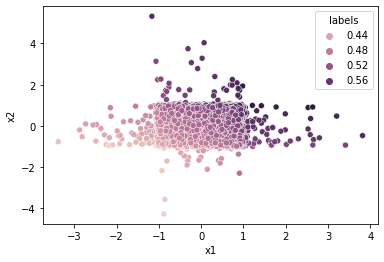

In [11]:
accuracy = metrics.BinaryAccuracy()
LR = 1e-3
NUM_EPOCHS = 10

loss = 0
val_loss = 0
history = []

learning_rate = tf.Variable(LR, trainable=False)
optimizer = tf.keras.optimizers.Adam(learning_rate)

y_true = train_dict[0]['labels']
y_pred, y_var, grad = diglm(train_dict[0]['features'])
print(y_true)
print(y_pred.numpy().T)

accuracy.update_state(y_true, y_pred.numpy().T)
print(f'Binary accuracy: {accuracy.result().numpy():.3f}')

for epoch in range(NUM_EPOCHS):
  accuracy.reset_state()
  y_true = train_dict[0]['labels']
  y_pred, y_var, grad = diglm(train_dict[0]['features'])
  accuracy.update_state(y_true, y_pred.numpy().T)
  print(f'Binary accuracy: {accuracy.result().numpy():.3f}')
  print(f'Epoch = {epoch+1} Loss = {loss:.3f}.')
  for batch in train_dict:
    loss = train_step(optimizer, batch)
  plot()

